# Lecture 5: Linear and Logistic regression with JAX

In this lecture we will try to build a simple model of linear and logistic regression using JAX and
it's auto-grad capabilities.

## Linear regression

Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables. It assumes a linear relationship, aiming to find the best-fit line that minimizes the difference between predicted and actual values.

With a single independent variable, it's expressed as $ y = Wx + b $, where $y$ is the dependent variable, $x$ is the independent variable, $W$ is the slope, and $b$ is the intercept. Linear regression is widely applied in various fields for prediction, analysis, and understanding relationships between variables.

Let's start with the imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

### Data preparation

We will create a some random data set that will use for training our model.

Here, we have assume that $W=3$ and $b=2$.

We will take 10 data points as $X$ and compute `y_actual` using $Wx+b$ and then add some random noise using normal distribution to compute our $y$.

In [2]:
actual_W = 3.0
actual_b = 2.0
num_points = 10

key = jax.random.PRNGKey(0)
X = jnp.arange(num_points).reshape((num_points, 1))
y_actual = actual_W * X + actual_b
noise = jax.random.normal(key, (num_points, 1))
y = y_actual + noise

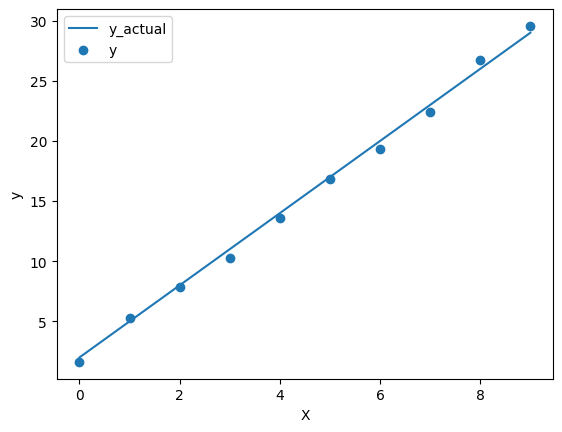

In [3]:
plt.plot(X, y_actual, label='y_actual')
plt.scatter(X, y, label='y')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Now, let's define the following two functions

1. **Forward Pass Function (`forward`):**
   - The `forward` function takes input `x` and model parameters `params` (which include weights `W` and biases `b`) as input.
   - It computes the forward pass of the neural network by performing a dot product between the input `x` and the weights `W`, and then adding the biases `b`.
   - The result is the output of the neural network.


2. **Loss Function (`loss_fn`):**
   - The `loss_fn` function takes input `x`, ground truth labels `y`, and model parameters `params` as input.
   - It first computes predictions using the `forward` function.
   - Then, it computes the mean squared error loss between the predictions and the ground truth labels.
   - This loss function quantifies the discrepancy between the predicted and actual values, providing a measure of how well the model is performing on the given data.

In [4]:
# Forward pass
@jax.jit
def forward(params, x):
    return jnp.dot(x, params['W']) + params['b']

# Define loss function of linear regression
@jax.jit
def loss_fn(params, x, y):
    preds = forward(params, x)
    return jnp.mean((preds - y) ** 2)

We define a gradient function `grad_fn` using JAX's `grad` function, which computes the gradients of a given function (in this case, the loss function `loss_fn`) with respect to its input arguments.

In [5]:
# Define gradient function
grad_fn = jax.jit(jax.grad(loss_fn))

Next, we define a training loop where we iterate over a fixed number of epochs (`num_epochs`). In each epoch, we compute the gradients of the loss function with respect to the model parameters using `grad_fn`. These gradients indicate the direction and magnitude of change needed to minimize the loss.

After computing the gradients, we update the model parameters (`params['W']` and `params['b']`) using gradient descent. This involves subtracting a fraction of the gradients from the current parameter values, scaled by a learning rate (`lr`). The learning rate controls the size of the step taken in the parameter space during optimization.

In [6]:
# Define model parameters (Initialize them)
params = {
    'W': jax.random.normal(key, (1, 1)),
    'b': jnp.zeros((1,))
}

In [7]:
lr = 0.01
num_epochs = 1000
for epoch in range(num_epochs):
    # Compute gradients
    grads = grad_fn(params, X, y_actual)
    # Update parameters
    params['W'] -= lr * grads['W']
    params['b'] -= lr * grads['b']

In [8]:
print("Trained Parameters:")
print("W:", params['W'])
print("b:", params['b'])

Trained Parameters:
W: [[3.0008037]]
b: [1.9949604]


This is almost the same that we had assumed earlier while creating our dataset.

## Logistic regression

Logistic regression is a statistical method used for binary classification tasks. Unlike linear regression, it models the probability that a given input belongs to a particular class using the logistic function, which maps input values to the range [0, 1].

It estimates the coefficients of the decision boundary that separates the classes, making it a linear classifier.

To begin with logistic regression, let's create a small dataset with 5 data points.

In [9]:
key = jax.random.PRNGKey(10)

X = jnp.array([[1, 3], [3, 5], [2, 4], [6, 2], [5, 1]])
y = jnp.array([1, 1, 1, 0, 0]).reshape((5, 1))  # Binary labels (0 or 1)

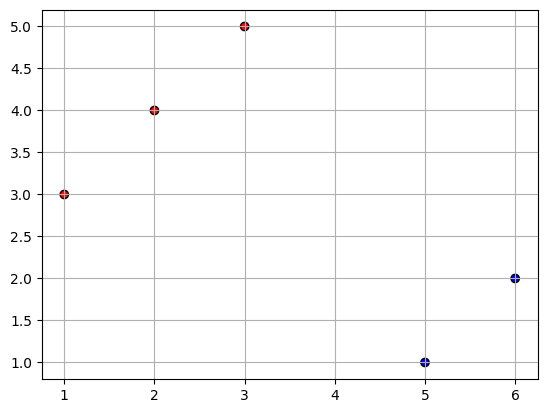

In [10]:
# Plot dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
plt.grid(True)
plt.show()

Now, let's define the following functions

1. **Sigmoid Activation Function:**
   - The `sigmoid` function is a mathematical function that maps any real-valued number to the range [0, 1].
   - It is used as the activation function in logistic regression to squash the output of the linear combination of inputs to a probability value.

2. **Forward Pass Function:**
   - The `forward` function performs the forward pass of the logistic regression model.
   - It takes the input features `x` and the model parameters `params` (including weights `W` and bias `b`) as input.
   - It computes the linear combination of input features and model weights, adds the bias term, and applies the sigmoid activation function to obtain the predicted probabilities.

3. **Binary Cross-Entropy Loss Function:**
   - The `loss_fn` function calculates the binary cross-entropy loss between the predicted probabilities and the ground truth labels `y`.
   - It first computes the predicted probabilities using the `forward` function.
   - It then calculates the cross-entropy loss, which measures the discrepancy between the predicted probabilities and the actual binary labels.

In [11]:
# Define the sigmoid activation function
@jax.jit
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))


# Forward pass function
@jax.jit
def forward(params, x):
    return sigmoid(jnp.dot(x, params['W']) + params['b'])


# Define binary cross-entropy loss function
@jax.jit
def loss_fn(params, x, y):
    preds = forward(params, x)
    return -jnp.mean(y * jnp.log(preds) + (1 - y) * jnp.log(1 - preds))

Next, similar to liner regression, we define a training loop where we iterate over a fixed number of epochs (`num_epochs`). In each epoch, we compute the gradients of the loss function with respect to the model parameters using `grad_fn`.

After computing the gradients, we update the model parameters (`params['W']` and `params['b']`) using gradient descent. This involves subtracting a fraction of the gradients from the current parameter values, scaled by a learning rate (`lr`). The learning rate controls the size of the step taken in the parameter space during optimization.

In [12]:
# Define model parameters
params = {
    'W': jax.random.normal(key, (2, 1)),
    'b': jnp.zeros((1,))
}

# Define gradient function
grad_fn = jax.jit(jax.grad(loss_fn))

In [13]:
lr = 0.01
num_epochs = 1000
for epoch in range(num_epochs):
    # Compute gradients
    grads = grad_fn(params, X, y)
    # Update parameters using gradient descent
    params['W'] -= lr * grads['W']
    params['b'] -= lr * grads['b']

# Print trained parameters
print("Trained Parameters:")
print("W:", params['W'])
print("b:", params['b'])

Trained Parameters:
W: [[-1.0959495]
 [ 1.3521521]]
b: [0.428438]


Let's see how the predicted boundary looks like

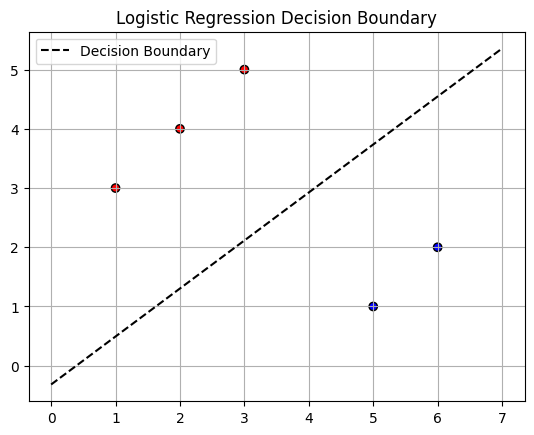

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
W, b = params['W'], params['b']
# Generate x values for decision boundary line
x_values = jnp.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
# Compute y values for decision boundary line using the formula: W0*x + W1*y + b = 0
y_values = (-b - W[0] * x_values) / W[1]

# Plot decision boundary line
plt.plot(x_values, y_values, color='k', linestyle='--', label='Decision Boundary')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()

## References

- [JAX Documentation](https://jax.readthedocs.io/en/latest/index.html)